(sec:correlation)=
# Electron correlation

Electron correlation stem from the instantaneous interactions between electrons. It manifests itself as a relationship between [one- and two-electron densities](sec:reduced_densities) 

$$
n(\mathbf{r}, \mathbf{r}') \neq n(\mathbf{r}) n(\mathbf{r}')
$$

where $n(\mathbf{r}, \mathbf{r}')$ is the two-electron density. If the molecular system is described by an approximate wave function that does not capture this instantaneous electron interaction, then the relationship between densities (incorrectly) becomes 

$$
n(\mathbf{r}, \mathbf{r}') = n(\mathbf{r}) n(\mathbf{r}')
$$

indicating completely independent motions of electrons.

## Correlation energy

Electron correlation arises from two primary sources namely the fermionic nature of electrons and the Coulomb repulsion between electrons. From the perspective of the Hartree–Fock method, the first but not the second source is accounted for, and as a measure of this discrepancy the correlation energy is defined as

$$
E_{\textrm{corr}} = E_{\textrm{exact}} - E_{\textrm{HF}} 
$$

In work with approximate methods such as the plethora of wave function models, it is convenient to introduce a method specific correlation energy following Löwdin {cite:p}`Lowdin1980`

$$
E_{\textrm{corr}} = E_{\textrm{WF}} - E_{\textrm{HF}}  
$$

where $E_{\textrm{WF}}$ is the energy of the molecular system computed by the selected wave function model.

To illustrate these concepts, we will use the full configuration interaction (FCI) method to study the H$_2$ molecule. The obtained results provide the exact correlation energy for the given basis set.

In [1]:
import matplotlib.pyplot as plt
import multipsi as mtp
import numpy as np
import veloxchem as vlx

np.set_printoptions(precision=6, suppress=True, linewidth=170)

mol_str = """
H     0.000000    0.000000   -0.70
H     0.000000    0.000000    0.70
"""
molecule = vlx.Molecule.read_str(mol_str, units="au")
basis = vlx.MolecularBasis.read(molecule, "cc-pvdz")

norb = basis.get_dimensions_of_basis(molecule)

scf_drv = vlx.ScfRestrictedDriver()
scf_results = scf_drv.compute(molecule, basis)

hf_energy = scf_drv.get_scf_energy()

space = mtp.OrbSpace(molecule, scf_drv.mol_orbs)
space.FCI()

ci_drv = mtp.CIDriver()
ci_drv.compute(molecule, basis, space)

ci_energy = ci_drv.getEnergy(0)

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 4.
* Info * Reading basis set from file: /Users/panor/opt/miniconda3/envs/echem/lib/python3.9/site-packages/veloxchem/basis/CC-PVDZ
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                                  Basis: CC-PVDZ                                                                          
                                                                                                                          
                                  Atom Contracted GTOs          Primitive GTOs                                            
                                 

The correlation energy is small compared to the absolute energy.

In [2]:
print(f"HF energy: {hf_energy : .8f}")
print(f"CI energy: {ci_energy : .8f}")
print(f"Correlation energy: {ci_energy - hf_energy : .8f}")

HF energy: -1.12870945
CI energy: -1.16339873
Correlation energy: -0.03468928


## Visualizing electron correlation

### One-particle density

With access to both the Hartree–Fock and FCI wave functions, we can investigate the densities using the `VisualizationDriver` class in Veloxchem.

This module gives us access to the orbital values at specified coordinates.

In [3]:
vis_drv = vlx.VisualizationDriver()

In [4]:
def get_orbital_values(coords, molecule, basis, mol_orbs):

    orbital_values = []

    for i in range(norb):

        values = np.array(vis_drv.get_mo(coords, molecule, basis, mol_orbs, i, "alpha"))
        orbital_values.append(values)

    return orbital_values

The one-particle density equals the product of the density matrix and orbital densities.

In the MO basis, the HF density matrix is diagonal with elements 2 and 0 for occupied and unoccupied orbitals, respectively. For CI, it is a bit more complicated, but the density matrix is provided by the CI driver.

In [5]:
def get_n1(orbital_values):

    hf_onepart_denmat = np.zeros((norb, norb))
    hf_onepart_denmat[0, 0] = 2.0  # first MO is doubly occupied
    fci_onepart_denmat = ci_drv.get1den(0)

    # One-particle densities for HF and FCI
    n1_hf = np.zeros(n)
    n1_fci = np.zeros(n)
    
    for i in range(norb):
        for j in range(norb):

            n1_hf += hf_onepart_denmat[i, j] * orbital_values[i] * orbital_values[j]
            n1_fci += fci_onepart_denmat[i, j] * orbital_values[i] * orbital_values[j]

    return n1_hf, n1_fci

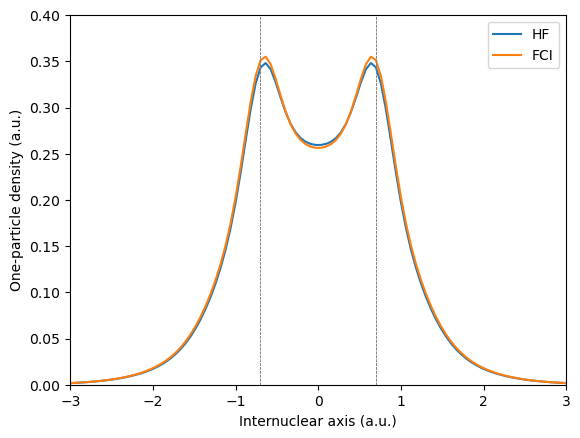

In [6]:
n = 100
coords = np.zeros((n, 3))
coords[:, 2] = np.linspace(-3, 3, n, endpoint=True)

orbital_values = get_orbital_values(coords, molecule, basis, scf_drv.mol_orbs)

n1_hf, n1_fci = get_n1(orbital_values)

plt.plot(coords[:, 2], n1_hf, label="HF")
plt.plot(coords[:, 2], n1_fci, label="FCI")
plt.legend()

plt.axvline(x=0.70, color="0.5", linewidth=0.7, dashes=[3, 1, 3, 1])
plt.axvline(x=-0.70, color="0.5", linewidth=0.7, dashes=[3, 1, 3, 1])
plt.setp(plt.gca(), xlim=(-3, 3), ylim=(0, 0.40))

plt.ylabel("One-particle density (a.u.)")
plt.xlabel("Internuclear axis (a.u.)")

plt.show()

The differences one-particle densities at the HF and FCI levels of theory are very minor. Upon close inspection of the FCI density, it is possible to discern a small decrease in the middle of the bond, compensated for by a minor increase around the nuclei. 

### Two-particle density

Given the nature of electron correlation, it is in the two-particle density that approximate method shortcomings are expected to more clearly reveal themselves. 

In [7]:
def get_n12(orbital_values_1, orbital_values_2):

    hf_twopart_denmat = np.zeros((norb,norb,norb,norb))
    hf_twopart_denmat[0,0,0,0] = 2.0 # first MO is doubly occupied
    ci_twopart_denmat = ci_drv.get2den(0)
    
    # Two-particle densities for HF and FCI
    n12_hf = np.zeros(n)
    n12_fci = np.zeros(n)

    for i in range(norb):
        for j in range(norb):
            for k in range(norb):
                for l in range(norb):

                    n12_hf += (
                        hf_twopart_denmat[i, j, k, l]
                        * orbital_values_1[i]
                        * orbital_values_1[j]
                        * orbital_values_2[k]
                        * orbital_values_2[l]
                    )

                    n12_fci += (
                        ci_twopart_denmat[i, j, k, l]
                        * orbital_values_1[i]
                        * orbital_values_1[j]
                        * orbital_values_2[k]
                        * orbital_values_2[l]
                    )

    return n12_hf, n12_fci

Let us determine the probability density for finding one electron at the position of the hydrogen nucleus and the other at any point on the internuclear axis.

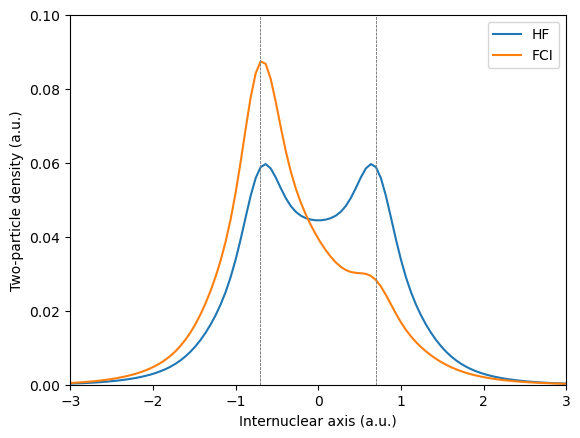

In [8]:
# electron 1 at the position of the hydrogen nucleus
orbital_values_at_H1 = get_orbital_values([[0, 0, 0.70]], molecule, basis, scf_drv.mol_orbs)

n12_hf, n12_fci = get_n12(orbital_values_at_H1, orbital_values)

plt.plot(coords[:, 2], n12_hf, label="HF")
plt.plot(coords[:, 2], n12_fci, label="FCI")

plt.legend()

plt.axvline(x=0.70, color="0.5", linewidth=0.7, dashes=[3, 1, 3, 1])
plt.axvline(x=-0.70, color="0.5", linewidth=0.7, dashes=[3, 1, 3, 1])
plt.setp(plt.gca(), xlim=(-3, 3), ylim=(0, 0.10))

plt.ylabel("Two-particle density (a.u.)")
plt.xlabel("Internuclear axis (a.u.)")

plt.show()

It is here clearly shown how the HF wave functions fails to describe the asymmetry in the two-particle density.

As correctly captured by the FCI wave function, the probability for finding both electrons positioned at the same (right-most) hydrogen nucleus should be smaller than to find the electrons positioned at different nuclei.

### Electron cusp and basis set convergence

The point charge model of atomic nuclei creates cusp in the MOs, *i.e.*, a discontinuity in their derivatives at the positions of the nuclei.

Likewise, the point charge of a given electron creates a cusp in the wave function relating to any of the other electrons. 

As standard quantum chemistry methods does not introduce any explicit dependence on the inter-electronic distances, it is expected that this electron–electron cusp displays a slow convergence. 

As an illustration of this fact, let us study the helium atom with one electron fixed in space and the other one positioned on a circle such that their positions coincide at one point.

In [17]:
molecule = vlx.Molecule.read_str("He  0.0 0.0 0.0")

theta = np.linspace(-np.pi, np.pi, n, endpoint=True)
coords = np.zeros((n, 3))
coords[:, 0] = 0.70 * np.cos(theta)
coords[:, 1] = 0.70 * np.sin(theta)

# one- and two-particle densities for each basis set in lists
n12_fci_l = []

for basis_set in ["sto-3g", "cc-pvdz", "cc-pvtz"]:

    basis = vlx.MolecularBasis.read(molecule, basis_set)
    norb = basis.get_dimensions_of_basis(molecule)
    scf_results = scf_drv.compute(molecule, basis)

    space = mtp.OrbSpace(molecule, scf_drv.mol_orbs)
    space.FCI()

    ci_drv = mtp.CIDriver()
    ci_drv.compute(molecule, basis, space)

    orbital_values_1 = get_orbital_values([[0.70, 0, 0]], molecule, basis, scf_drv.mol_orbs)
    orbital_values_2 = get_orbital_values(coords, molecule, basis, scf_drv.mol_orbs)

    _, n12_fci = get_n12(orbital_values_1, orbital_values_2)

    n12_fci_l.append(n12_fci)

* Info * Reading basis set from file: /Users/panor/opt/miniconda3/envs/echem/lib/python3.9/site-packages/veloxchem/basis/STO-3G
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                                  Basis: STO-3G                                                                           
                                                                                                                          
                                  Atom Contracted GTOs          Primitive GTOs                                            
                                                                                                                          
           

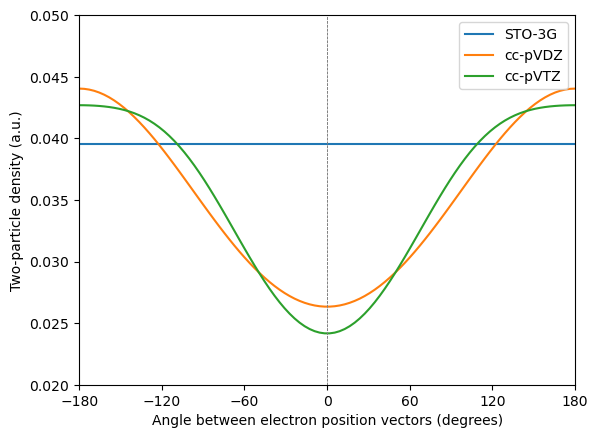

In [18]:
plt.plot(theta * 180 / np.pi, n12_fci_l[0], label="STO-3G")
plt.plot(theta * 180 / np.pi, n12_fci_l[1], label="cc-pVDZ")
plt.plot(theta * 180 / np.pi, n12_fci_l[2], label="cc-pVTZ")
plt.legend()

plt.axvline(x=0, color="0.5", linewidth=0.7, dashes=[3, 1, 3, 1])
plt.setp(plt.gca(), xlim=(-180, 180), ylim=(0.02, 0.05), xticks=range(-180, 190, 60))

plt.ylabel("Two-particle density (a.u.)")
plt.xlabel("Angle between electron position vectors (degrees)")

plt.show()

The basis set effect is seen to be large.

With the minimal STO-3G basis set there are no virtual orbitals and therefore the electron correlation is not captured.

With increased basis set quality, the cusp gets sharper but convergence is slow. This illustrates why correlated wave function methods require large and flexible basis sets to converge. 

For HF and DFT, in contrast, the basis set only needs to accommodate an accurate description of the one-particle density and convergence is therefore much faster.